In [100]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()

# env.render()

In [101]:
# some initializations
n_states = 40
episodes = 40
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped
env.seed()
np.random.seed(0)

In [ ]:
# Quantize the states
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

In [ ]:
q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0

In [ ]:
steps_history = []
reward_history = []
for episode in range(episodes):
    print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        # env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        
        # Q function update
        #
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        steps += 1
        if terminate:
            steps_history.append(steps)
            reward_history.append(total_reward)
            break

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39


Text(0.5, 1.0, 'Steps change with episodes')

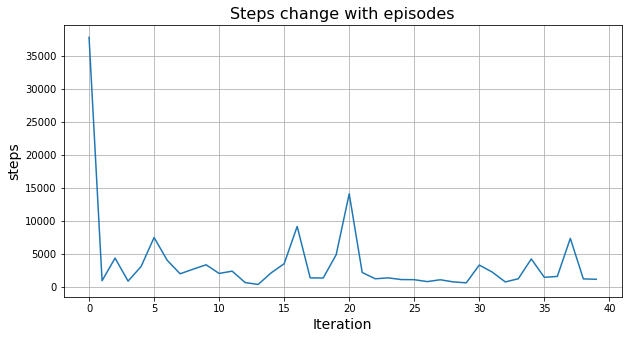

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(steps_history)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("steps", fontsize=14)
ax.grid(True)
ax.set_title("Steps change with episodes", fontsize=16)

In [ ]:
def design_matrix_U(X, J):
  N = X.shape[0]
  kmeans_results =  KMeans(n_clusters=J, random_state=0).fit(X)
  U = np.zeros((N, J))
  for i in range(N):
    for j in range(J):
      U[i][j] = np.linalg.norm(X[i] - kmeans_results.cluster_centers_[j])
  return U

In [ ]:
high = env.observation_space.high
low = env.observation_space.low
pos = np.linspace(low[0], high[0], n_states)
vel = np.linspace(low[1], high[1], n_states)

X = np.dstack([pos, vel]).reshape(n_states, 2)

def apr_x_rbf(X, q_table, J):
    U = design_matrix_U(X, J)            
    w = np.dot((np.linalg.inv(np.dot(U.T, U))), U.T) @ q_table.reshape(U.shape[0], -1)
    y_rbf = U @ w
    y_rbf = y_rbf.reshape(n_states, n_states, 3)
    return y_rbf

In [ ]:
def drive_y_rbf(y_rbf, episodes):
    steps_count = []
    for episode in range(episodes):
        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
            # env.render()
            pos, vel = discretization(env, obs)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
            else:
                a = np.argmax(y_rbf[pos][vel])
            obs, reward, terminate,_ = env.step(a)
            total_reward += abs(obs[0]+0.5)
            steps += 1
            if terminate:
                steps_count.append(steps)
                break
    return steps_count

In [ ]:
y_rbf_j3 = apr_x_rbf(X, q_table, J=3)
steps_history_3 = drive_y_rbf(y_rbf_j3, episodes)

y_rbf_j5 = apr_x_rbf(X, q_table, J=5)
steps_history_5 = drive_y_rbf(y_rbf_j5, episodes)

y_rbf_j20 = apr_x_rbf(X, q_table, J=20)
steps_history_20 = drive_y_rbf(y_rbf_j20, episodes)

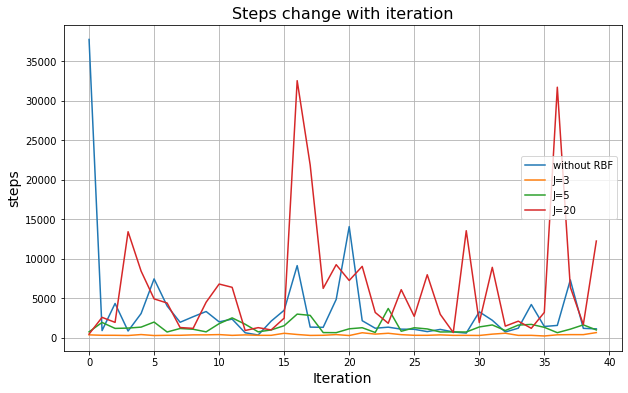

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(steps_history, label='without RBF')
ax.plot(steps_history_3, label='J=3')
ax.plot(steps_history_5, label='J=5')
ax.plot(steps_history_20, label='J=20')
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("steps", fontsize=14)
ax.grid(True)
ax.set_title("Steps change with iteration", fontsize=16)
plt.legend()

## 1.2.2

### 1.2.2.1 Sarsa learning

In [102]:
import matplotlib
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
import sklearn.pipeline
import sklearn.preprocessing
import math

env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()

In [103]:
# some initializations
episodes = 300
initial_lr = 0.1
min_lr = 0.005
gamma = 0.99
epsilon = 0.05
action_n = env.action_space.n

env = env.unwrapped
env.seed()
np.random.seed(0)

In [104]:
J = 100

#Parameter vector define number of parameters per action based on featurizer size
w = np.zeros((action_n, J))

In [105]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Create radial basis function sampler to convert states to features for nonlinear function approx
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=math.floor(J/4))),
        ("rbf2", RBFSampler(gamma=2.5, n_components=math.floor(J/4))),
        ("rbf3", RBFSampler(gamma=1.5, n_components=math.floor(J/4))),
        ("rbf4", RBFSampler(gamma=0.5, n_components=math.floor(J/4))),
        ])
featurizer.fit(scaler.transform(observation_examples))

# Normalize
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized

def Q_function(state, action, w):
    value = state.dot(w[action])
    return value

# action policy
def action_policy(state, weight, epsilon=epsilon):
    A = np.ones(action_n, dtype=float) * epsilon/action_n
    best_action =  np.argmax([Q_function(state,a,w) for a in range(action_n)])
    A[best_action] += (1.0-epsilon)
    sample = np.random.choice(action_n, p=A)
    return sample

In [ ]:
rewards_history = np.zeros(episodes)
steps_history_sarsa = []
for episode in range(episodes):
    state = featurize_state(env.reset())  
    alpha = max(min_lr, initial_lr * (gamma ** (episode//10)))
    steps = 0
    while True:
        # env.render()
        action = action_policy(state, w)
        obs, reward, terminate, _ = env.step(action)
        rewards_history[episode] += reward
        
        next_state = featurize_state(obs)
        next_action = action_policy(next_state, w)

        target = reward + gamma * Q_function(next_state, next_action, w)
        error = Q_function(state, action, w) - target

        dw = (error).dot(state)
        state = next_state

        # Update weight
        w[action] -= alpha * dw
        
        steps += 1
        if terminate:
            steps_history_sarsa.append(steps)
            break

In [ ]:
def plot_cost_to_go(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([Q_function(featurize_state(_),a,w) for a in range(action_n)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=0.0, vmax=70.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Speed')
    ax.set_zlabel('Value')
    ax.set_title("Mountain\"Cost To Go\"Sarsa Learning")
    fig.colorbar(surf)
    plt.show()
env.close()

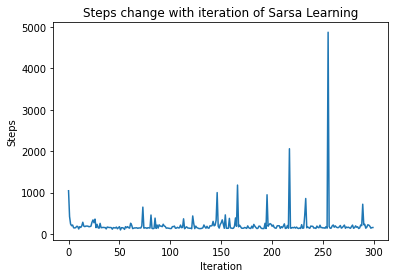

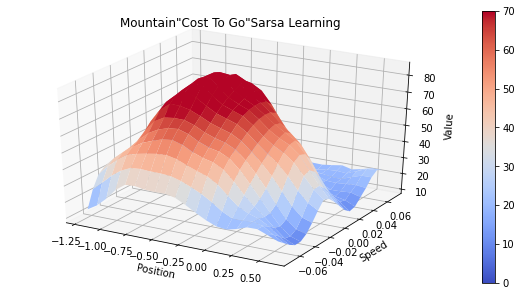

In [ ]:
plt.figure()
plt.plot(np.arange(episodes), steps_history_sarsa)
plt.xlabel("Iteration")
plt.ylabel("Steps")
plt.title("Steps change with iteration of Sarsa Learning")
plt.show()
plot_cost_to_go()

### 1.2.2.2 

In [106]:
rewards_history = np.zeros(episodes)
steps_history_Q = []
actions = range(env.action_space.n)
for episode in range(episodes):
    state = featurize_state(env.reset())  
    alpha = max(min_lr, initial_lr * (gamma ** (episode//10)))
    steps = 0
    while True:
        # env.render()
        action = action_policy(state, w)
        obs, reward, terminate, _ = env.step(action)
        rewards_history[episode] += reward
        
        next_state = featurize_state(obs)
        next_action = action_policy(next_state, w)
        
        target = reward + gamma * max([Q_function(next_state, a, w) for a in actions])
        error = Q_function(state, action, w) - target

        dw = (error).dot(state)
        state = next_state

        # Update weight
        w[action] -= alpha * dw
        
        steps += 1
        if terminate:
            steps_history_Q.append(steps)
            break

In [107]:
def plot_cost_to_go(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([Q_function(featurize_state(_),a,w) for a in range(action_n)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=0.0, vmax=70.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Speed')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\"Q Learning")
    fig.colorbar(surf)
    plt.show()
env.close()

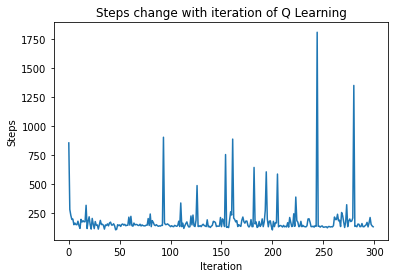

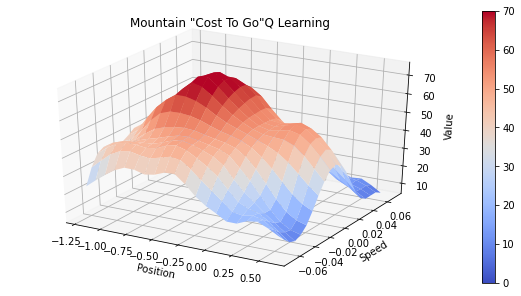

In [108]:
plt.figure()
plt.plot(np.arange(episodes), steps_history_Q)
plt.xlabel("Iteration")
plt.ylabel("Steps")
plt.title("Steps change with iteration of Q Learning")
plt.show()
plot_cost_to_go()